# Bank Test Data Analysis    

We are working with the performance data of a new sales team tasked with selling a diverse range of products to various customer segments. Our goal is to utilize the two provided datasets, merge the information, and simulate potential future scenarios. By integrating and analyzing the data, we aim to uncover actionable insights and create predictive models that allow us to forecast outcomes such as revenue trends and employee performance. Through this exercise, we are addressing both historical and future scenarios to support strategic planning and decision-making within the sales process.

We transferred the provided SQL code data into an SQLite dataset to create a structured and lightweight database for efficient management and analysis.

In [165]:
# Import libraries 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import sqlite3
import pandas as pd

In [166]:
# Define the path to your database
db_path = "../db_rbc.db"

# Connect to the SQLite database
connection = sqlite3.connect(db_path)

try:
    # Create a cursor object
    cursor = connection.cursor()

    # Fetch data from the 'Rev' table
    cursor.execute("SELECT * FROM Rev")
    rev_data = cursor.fetchall()
    rev_columns = [description[0] for description in cursor.description]  # Get column names
    rev_df = pd.DataFrame(rev_data, columns=rev_columns)

    # Fetch data from the 'RTAM_Emp_Mapping' table
    cursor.execute("SELECT * FROM RTAM_Emp_Mapping")
    rtam_emp_mapping_data = cursor.fetchall()
    rtam_emp_mapping_columns = [description[0] for description in cursor.description]  # Get column names
    rtam_emp_mapping_df = pd.DataFrame(rtam_emp_mapping_data, columns=rtam_emp_mapping_columns)

finally:
    # Close the connection
    connection.close()

The provided SQL code was executed, transformed, and used to create a DataFrame in the notebook. This DataFrame displayed the number of employees per region for each quarter, enabling efficient analysis and visualization.

In [167]:
# Create Rev_RTAM df 

# Connect to the SQLite database
connection = sqlite3.connect(db_path)

try:
    # Create a cursor object
    cursor = connection.cursor()

    # Execute the SQL query to generate the desired data
    query = """
    SELECT Region, Yr, COUNT(Employee_Name) AS Employee_Count_Region 
    FROM (
        SELECT M.Region, M.Employee_Name, R.Yr 
        FROM Rev R
        LEFT JOIN RTAM_Emp_Mapping M 
        ON CAST(R.RT || R.AM AS INTEGER) = M.RTAM
        WHERE R.Quarter = "Q1" 
          AND Transaction_Segment <> "Corporate"
        GROUP BY M.Region, M.Employee_Name, R.Yr
    ) AS E
    GROUP BY Region, Yr
    ORDER BY COUNT(Employee_Name) DESC;
    """
    cursor.execute(query)
    rev_rtam_data = cursor.fetchall()
    rev_rtam_columns = [description[0] for description in cursor.description]  # Get column names
    Rev_RTAM_df = pd.DataFrame(rev_rtam_data, columns=rev_rtam_columns)

finally:
    # Close the database connection
    connection.close()

Next, we cleaned the data by removing irrelevant columns and identifying the missing periods for 2025. We then examined the dataset to determine if there were any gaps in the data that required imputation, ensuring the dataset was prepared for accurate analysis and forecasting.

In [168]:
# Create a merged df 
rev_df['RTAM'] = (rev_df['RT'].astype(str) + rev_df['AM'].astype(str)).astype(int)
merged_df = rev_df.merge(rtam_emp_mapping_df, on='RTAM', how='left')

In [169]:
# Check for any null values in the entire merged_df table
null_values = merged_df.isnull().any().any()

if null_values:
    print("There are null values in the table.")
else:
    print("No null values in the table.")

No null values in the table.


In [170]:
# Drop the RT and AM columns from merged_df
merged_df = merged_df.drop(columns=['RT', 'AM'])

In [171]:
# Generate a complete set of Quarter-Year combinations within the range
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
years = range(merged_df['Yr'].astype(int).min(), merged_df['Yr'].astype(int).max() + 1)

# Create a full DataFrame of all possible Quarter-Year combinations
full_combinations = pd.DataFrame(
    [(str(year) + quarter) for year in years for quarter in quarters],
    columns=['Quarter_Year']
)

Next, we discovered that for the year 2025, the only missing periods were 2025Q3 and 2025Q4.

In [172]:
# Check for missing Quarter-Year combinations
existing_combinations = (
    merged_df['Yr'].astype(str) + merged_df['Quarter']
).drop_duplicates().reset_index(drop=True)

missing_combinations = pd.DataFrame(
    set(full_combinations['Quarter_Year']) - set(existing_combinations),
    columns=['Missing_Quarter_Year']
)

# Show missing Quarter-Year combinations
print("Missing Quarter-Year combinations:")
print(missing_combinations)


Missing Quarter-Year combinations:
  Missing_Quarter_Year
0               2025Q4
1               2025Q3


We decided to introduce the Quarter_Year feature to consolidate and simplify the time-based information in the dataset. This facilitated further analysis by providing a clear, unified representation of the quarters and years, making it easier to track trends and identify missing periods for forecasting.

In [173]:
# Add the Quarter_Year column to merged_df in the format '2022Q1'
merged_df['Quarter_Year'] = merged_df['Yr'].astype(str) + merged_df['Quarter']

We then merged all three DataFrames into a single, denormalized table, providing a comprehensive view of all available features. This integration ensured that the dataset was well-structured and ready for analysis, allowing us to seamlessly explore and utilize the full range of information for forecasting and trend identification.

In [174]:
# Perform a left join between merged_df and Rev_RTAM_df based on Region and Year
merged_df = merged_df.merge(
    Rev_RTAM_df[['Region', 'Yr', 'Employee_Count_Region']], 
    left_on=['Region', 'Yr'], 
    right_on=['Region', 'Yr'], 
    how='left'
)

Then, we analyzed employee continuity by identifying those who were present both at the start and the end of the dataset. Following this, we examined the names of employees for each quarter to understand their distribution and participation over time.

In [175]:
# Get the list of employees for 2025Q2 and 2022Q1
employees_2025Q2 = set(merged_df[merged_df['Quarter_Year'] == '2025Q2']['Employee_Name'])
employees_2022Q1 = set(merged_df[merged_df['Quarter_Year'] == '2022Q1']['Employee_Name'])

# Find employees present in both quarters
common_employees = employees_2025Q2.intersection(employees_2022Q1)

# Display the result
print("Employees present in both 2025Q2 and 2022Q1:")
print(common_employees)

Employees present in both 2025Q2 and 2022Q1:
{'Hannah', 'Jack', 'Caleb', 'Jennifer', 'Hazel', 'Anthony', 'Grace'}


In [176]:
# Check which employees have been present in each Quarter_Year
employees_by_quarter_year = merged_df.groupby('Quarter_Year')['Employee_Name'].unique()

# Display the result
for quarter_year, employees in employees_by_quarter_year.items():
    print(f"{quarter_year}: {', '.join(employees)}")


2022Q1: Jack, Hazel, Anthony, Grace, Caleb, Jennifer, Hannah
2022Q2: Caleb, Jennifer, Hannah, Jack, Anthony, Grace, Hazel
2022Q3: Hazel, Jack, Anthony, Caleb, Hannah, Grace, Jennifer, Violet
2022Q4: Anthony, Caleb, James, Jennifer, Grace, Violet, Hazel, Hannah, Jack
2023Q1: Grace, Andrew, James, Hazel, Caleb, Jack, Jennifer, Violet, Anthony, Hannah
2023Q2: Hannah, Andrew, James, Anthony, Caleb, Hazel, Violet, Jessica, Jennifer, Grace, Jack, Steven, Amelia
2023Q3: Hannah, Andrew, James, Anthony, Grace, Hazel, Violet, Jack, Aria, Jennifer, Steven, Caleb, Amelia, Jessica, Sebastian
2023Q4: Sebastian, Andrew, James, Aria, Jennifer, Grace, Anthony, Hazel, Jack, Caleb, Hannah, Steven, Violet, George, Jessica, Amelia
2024Q1: Hannah, Andrew, James, Sebastian, Amelia, Jessica, Hazel, Isabella, Violet, Anthony, Henry, Grace, Emily, Steven, Jack, Jennifer, Caleb, Jacob, Aria, George
2024Q2: Jacob, Violet, James, Anthony, Hannah, Amelia, Hazel, Jack, Aria, Emily, Jennifer, Steven, Andrew, Isabella

Finally, we created our final dataset, consolidating all cleaned, transformed, and merged data. This comprehensive dataset incorporated key features, such as the Quarter_Year

In [177]:
# Create a Final Dataset 
final_dataset = merged_df[['Transaction_Count', 'Transaction_Segment',
       'Credit_Exposure', 'Revenue', 'Employee_Name',
       'Region', 'Tenure', 'Quarter', 'Quarter_Year', 'Employee_Count_Region']].copy(deep=True)

# Forecast 2025 results by employee and justify results

The goal is to forecast the **revenue** for each employee in **2025Q3** and **2025Q4** based on historical transaction data, considering the relevant features such as:
- **Transaction_Count**
- **Transaction_Segment**
- **Credit_Exposure**
- **Region**
- **Tenure**
- **Employee_Count_Region**

The forecasting requires handling the data for **employees who joined during the period** as well as those who were already present, while making predictions based on available features.

The remaining features from the initial dataset, namely Transaction_Number, RT, and AM, are technical in nature and appear to have limited relevance for forecasting purposes.


### Combine Data for 2025Q3 and 2025Q4 For Further Forecasting  

In [178]:
# Create Forecast Data for 2025Q3 and 2025Q4 based on 2025Q2 data
q2_data = final_dataset[final_dataset['Quarter_Year'] == '2025Q2']

# Copy the data and adjust for 2025Q3 and 2025Q4
forecast_data_q3_q4 = q2_data.copy()
forecast_data_q3_q4['Quarter_Year'] = '2025Q3'  # Set to 2025Q3
forecast_data_q3_q4['Quarter'] = 'Q3'  # Set to 2025Q3

forecast_data_q3_q4_2 = forecast_data_q3_q4.copy()
forecast_data_q3_q4_2['Quarter_Year'] = '2025Q4'  # Set to 2025Q4
forecast_data_q3_q4_2['Quarter'] = 'Q4'  # Set to 2025Q4

# Combine the 2025Q3 and 2025Q4 data with the original dataset (excluding 2025Q3 and 2025Q4 from training)
final_dataset_combined = pd.concat([final_dataset, forecast_data_q3_q4, forecast_data_q3_q4_2])

### Data Preprocessing and Feature Engineering

The first step is to prepare the data for modeling. This includes:
- **Encoding categorical variables**: Categorical columns such as `Transaction_Segment`, `Region`, `Employee_Name`, and `Quarter_Year` are encoded because machine learning models like linear regression require numeric inputs. 
    - **One-hot encoding** is used to convert categorical columns into dummy/indicator variables, ensuring that the model can interpret these features properly.

- **Time Handling**: 
    - The `Quarter_Year` column is used to differentiate between actual historical data and future data, as the goal is to predict future revenue (for 2025Q3 and 2025Q4). We decide **not to use `Quarter_Year` as a feature** for predicting since it’s only available for the test/forecast period.
  
- **Data Splitting**: 
    - The dataset is split into **training** and **forecasting** datasets. The **training data** consists of all data **before 2025Q2**, and the **forecasting data** is for **2025Q3 and 2025Q4**. This split makes sense because the future data points (2025Q3 and 2025Q4) are unknown and need to be predicted.


### One-Hot Encode Categorical Variables

In [179]:
# List of categorical columns
categorical_columns = ['Transaction_Segment', 'Region', 'Employee_Name', 'Quarter']

# One-hot encode the categorical columns (including `Quarter_Year`)
final_dataset_encoded = pd.get_dummies(final_dataset_combined, columns=categorical_columns, drop_first=True)

### Prepare Features (X) and Target Variable (y)

In [180]:
# List of numerical columns
numerical_columns = ['Transaction_Count', 'Credit_Exposure', 'Tenure', 'Employee_Count_Region']

# Separate features (X) and target variable (y)
X = final_dataset_encoded.drop(columns=['Revenue'])  # Exclude Revenue for training
y = final_dataset_encoded['Revenue']

# Standardize the numerical features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

### Split the Data for Training and Testing

In [181]:
# Split the data: use data before 2025Q2 for training, data for 2025Q2 for testing, and 2025Q3 & 2025Q4 for forecasting

# Training data (everything before 2025Q2)
X_train = X[X['Quarter_Year'] != '2025Q2']  # Exclude 2025Q2
y_train = y[X['Quarter_Year'] != '2025Q2']  # Target variable for training data

# Testing data (2025Q2 only)
X_test = X[X['Quarter_Year'] == '2025Q2']  # 2025Q2 data for testing
y_test = y[X['Quarter_Year'] == '2025Q2']  # Target variable for testing data

# Forecasting data (2025Q3 and 2025Q4)
X_forecast = pd.concat([X[X['Quarter_Year'] == '2025Q3'], X[X['Quarter_Year'] == '2025Q4']])

# Check the shape of the split datasets
X_train.shape, X_test.shape, X_forecast.shape


((585, 31), (39, 31), (78, 31))

#### Correlation Matrix For Feature Selection

The correlation matrix reveals the relationships between various features and **Revenue**. Notably, the **Transaction_Segment_Corporate** (0.61), **Credit_Exposure** (0.58), and **Transaction_Count** (0.56) have the strongest positive correlations with revenue, indicating that these variables are closely associated with higher revenue. Additionally, **Employee_Count_Region** (0.42) shows a moderate positive correlation with revenue, suggesting that regions with more employees tend to generate higher revenue.

On the other hand, several **Employee_Name** variables exhibit very weak correlations with revenue, with most values below 0.12. This suggests that individual employee names (such as **Isabella**, **Emily**, and others) have minimal impact on the overall revenue prediction. **Tenure** also shows a slightly negative correlation (-0.10), indicating that employees with longer tenures may not have a strong influence on revenue growth.

Finally, some variables, like **Transaction_Segment_Middle Market** (-0.30), **Quarter_Q2** (-0.04), and **Employee_Name** variables like **Andrew** (-0.07), show weak to moderate negative correlations, meaning these features may have a slightly inhibitory effect on revenue generation.


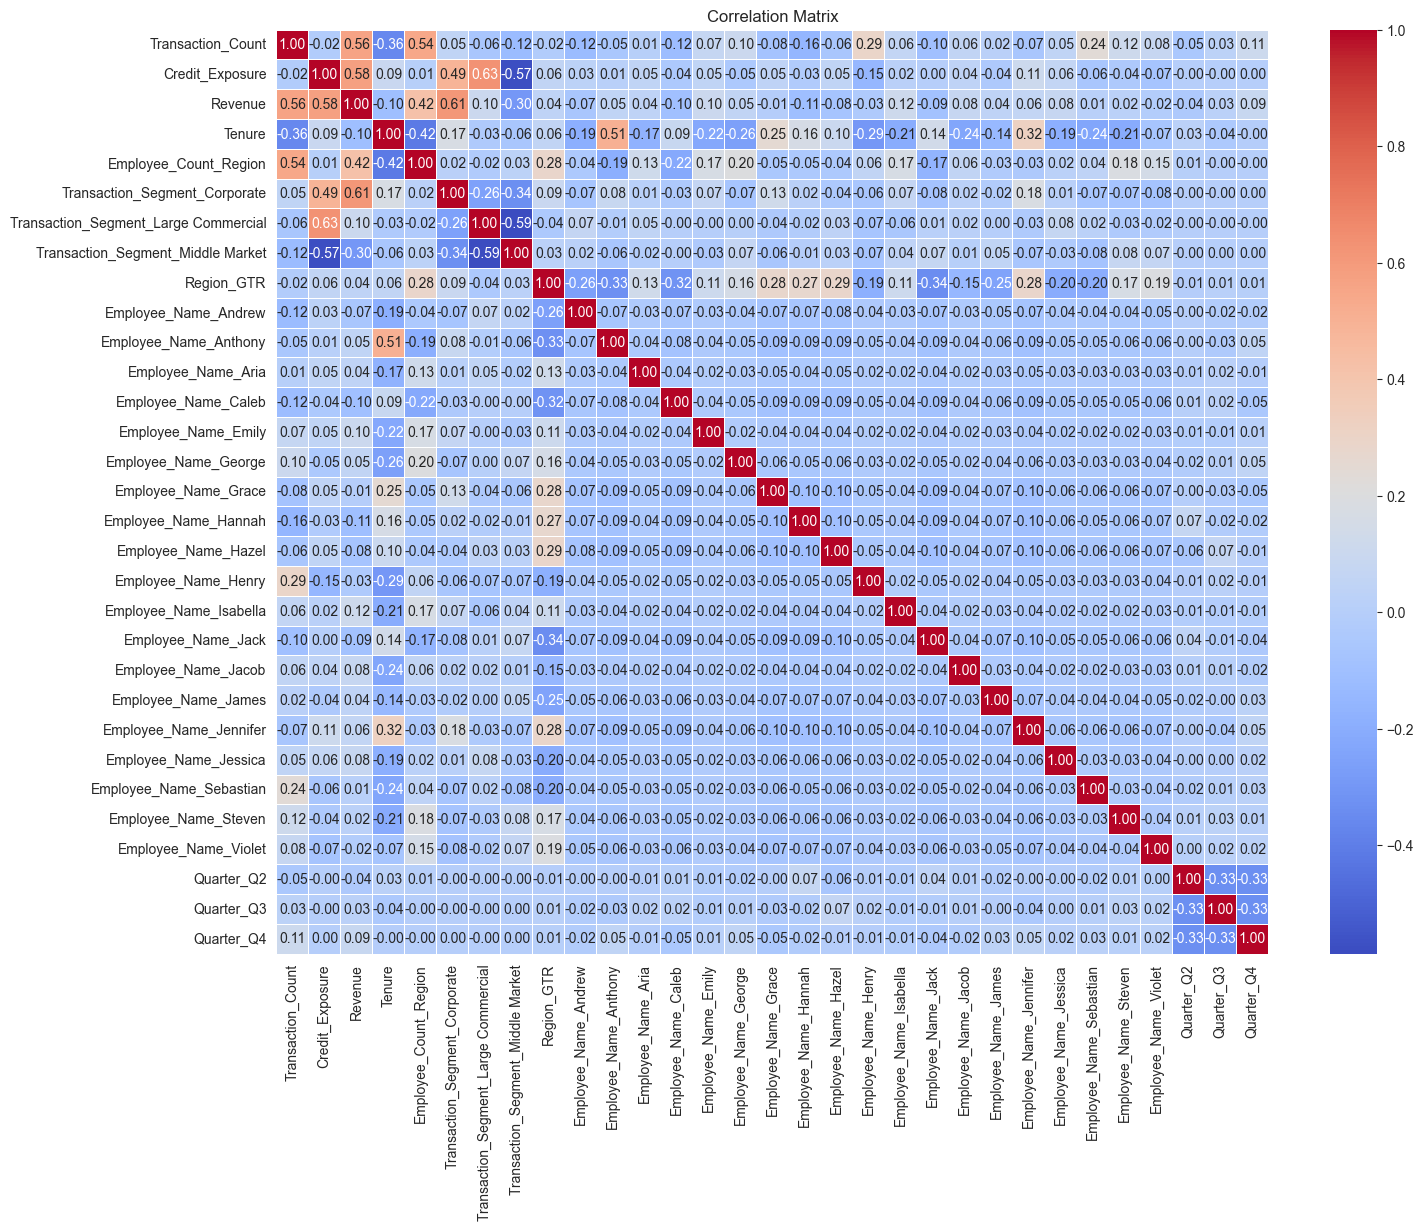

Revenue                                 1.000000
Transaction_Segment_Corporate           0.614454
Credit_Exposure                         0.575506
Transaction_Count                       0.561551
Employee_Count_Region                   0.418772
Employee_Name_Isabella                  0.116423
Employee_Name_Emily                     0.103974
Transaction_Segment_Large Commercial    0.103847
Quarter_Q4                              0.088758
Employee_Name_Jacob                     0.081606
Employee_Name_Jessica                   0.081299
Employee_Name_Jennifer                  0.063634
Employee_Name_George                    0.053051
Employee_Name_Anthony                   0.051737
Employee_Name_Aria                      0.044209
Employee_Name_James                     0.042347
Region_GTR                              0.039814
Quarter_Q3                              0.026291
Employee_Name_Steven                    0.024025
Employee_Name_Sebastian                 0.008972
Employee_Name_Grace 

In [202]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = final_dataset_encoded.drop(columns=['Quarter_Year']).corr()

# Plot the correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()



Below is the table presenting correlations between `Revenue` (our target variable for forecasting revenue per employee) and the various features. This correlation analysis serves as one of the foundational pillars for feature selection, alongside F-score and p-value analysis. These metrics collectively guide us in identifying the most relevant features to enhance the accuracy and reliability of the forecasting model.


In [213]:
# Check correlation with the target (Revenue)
print(correlation_matrix['Revenue'].sort_values(ascending=False))

Revenue                                 1.000000
Transaction_Segment_Corporate           0.614454
Credit_Exposure                         0.575506
Transaction_Count                       0.561551
Employee_Count_Region                   0.418772
Employee_Name_Isabella                  0.116423
Employee_Name_Emily                     0.103974
Transaction_Segment_Large Commercial    0.103847
Quarter_Q4                              0.088758
Employee_Name_Jacob                     0.081606
Employee_Name_Jessica                   0.081299
Employee_Name_Jennifer                  0.063634
Employee_Name_George                    0.053051
Employee_Name_Anthony                   0.051737
Employee_Name_Aria                      0.044209
Employee_Name_James                     0.042347
Region_GTR                              0.039814
Quarter_Q3                              0.026291
Employee_Name_Steven                    0.024025
Employee_Name_Sebastian                 0.008972
Employee_Name_Grace 

### Model Choice and Feature Selection

We choose **Linear Regression** for the forecasting task due to its simplicity, interpretability, and effectiveness for numerical prediction problems.

- **Feature Selection**: 
    - We evaluate the features that have the most **predictive power** for revenue. A **p-value threshold of 0.05** is used to select features, based on statistical tests. Only those features with a p-value ≤ 0.05 are kept. This ensures that we focus on the most statistically significant features for forecasting.
    - Additionally, **F-scores** are used to rank the features by their importance, which helps discard features with little impact on the model’s prediction accuracy.
  

### Technical Remarks Related to Forecasting and Model Choice 

In this analysis, we chose a linear regression model to forecast revenue for each employee rather than using a time series approach. The decision to use linear regression was based on the structure of the data, which involved multiple employees with varying histories and available features, rather than a single continuous time series. Given that the dataset contains both categorical and numerical features that vary across employees and quarters, a linear regression model was ideal for capturing the relationships between these variables and revenue.

We carefully selected features that we believed would have the most predictive power in forecasting revenue. These included **Transaction_Count**, **Transaction_Segment**, **Credit_Exposure**, **Employee_Count_Region**, and **Tenure**, among others. These features were chosen because they reflect factors directly influencing revenue generation. The **Transaction_Segment** and **Transaction_Count**, for instance, are strong indicators of business activity, while **Credit_Exposure** and **Employee_Count_Region** provide important contextual data about the environment in which each employee operates.

Although we did not use a time series model, we still accounted for seasonality in the data by including the **Quarter_Year** feature. This allowed us to capture the seasonal fluctuations in revenue that occur across different quarters, without the need to model time explicitly. By using the **Quarter_Year** as a feature, we incorporated temporal patterns while maintaining flexibility in the model for individual employee-level predictions.

Ultimately, this approach strikes a balance between simplicity and predictive power, allowing us to forecast revenue with high confidence while using a model that is easy to interpret and adapt.

#### Dependent Variables Predictive Power Analysis 

In [214]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

# Apply SelectKBest to select features with the highest relationship with the target
selector = SelectKBest(f_regression, k='all')  # 'all' will calculate scores for all features
selector.fit(X_train.drop(columns=['Quarter_Year']), y_train)

# Get the F-scores and p-values for each feature
f_scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame to display the F-scores and p-values
select_kbest_df = pd.DataFrame({
    'Feature': X_train.drop(columns=['Quarter_Year']).columns,
    'F-score': f_scores,
    'P-value': p_values
})

# Filter for features with p-value <= 0.05
significant_features = select_kbest_df[select_kbest_df['P-value'] <= 0.05].copy(deep=True)

# Format the P-value to avoid scientific notation
significant_features['P-value'] = significant_features['P-value'].apply(lambda x: f"{x:.6f}")

# Sort by F-score (high to low) and then by P-value (low to high)
sorted_features = significant_features.sort_values(by=['F-score', 'P-value'], ascending=[False, True])

# Create a list of selected features 
selected_features = list(sorted_features.Feature)

# Display the filtered results
print(sorted_features)

                                 Feature     F-score   P-value
4          Transaction_Segment_Corporate  365.812899  0.000000
0                      Transaction_Count  285.287179  0.000000
1                        Credit_Exposure  284.331317  0.000000
3                  Employee_Count_Region  118.708269  0.000000
6      Transaction_Segment_Middle Market   56.613004  0.000000
27                            Quarter_Q2   13.113687  0.000319
29                            Quarter_Q4    9.338386  0.002347
2                                 Tenure    6.436832  0.011437
11                   Employee_Name_Caleb    5.580526  0.018489
5   Transaction_Segment_Large Commercial    5.486641  0.019498
18                Employee_Name_Isabella    5.114053  0.024100
15                  Employee_Name_Hannah    4.931965  0.026748
12                   Employee_Name_Emily    4.645803  0.031538
19                    Employee_Name_Jack    4.263980  0.039370
20                   Employee_Name_Jacob    4.065014  0

### Train the Linear Regression Model

Once the data is prepared:
- We **train the linear regression model** using the data before 2025Q2. This allows us to leverage all the available historical data to predict future revenues.
- The data for **2025Q2** serves as the **test set** to evaluate model performance before using the model to predict future quarters (2025Q3 and 2025Q4).

In [184]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train[selected_features], y_train)

# Check the model's coefficients
model.coef_, model.intercept_

(array([3757.3536902 ,  851.0027711 ,   17.42072935,  153.91642968,
        1221.94050936,  -62.48818347,   94.76347079,   82.80464488,
         143.61417052, 1862.99963062,  362.68327565,  -67.62162286,
         196.34883068,   82.15767484,  323.95526113,  165.31771553]),
 np.float64(204.6299579886727))

In [185]:
# Make predictions for 2025Q2 (test data)
y_pred = model.predict(X_test[selected_features])

### Analyse the Linear Regression 

To evaluate the performance of the regression model, we use common metrics such as:
- **Mean Absolute Error (MAE)**
- **Mean Squared Error (MSE)**
- **Root Mean Squared Error (RMSE)**
- **R-Squared (R²)**

In [186]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Evaluate the model on the test set (for 2025Q2)
# MAE
mae = mean_absolute_error(y_test, y_pred)

# MSE
mse = mean_squared_error(y_test, y_pred)

# RMSE
rmse = np.sqrt(mse)

# R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Step 2: Print the evaluation metrics
print("Model Evaluation Metrics on Test Set (2025Q2):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Model Evaluation Metrics on Test Set (2025Q2):
Mean Absolute Error (MAE): 534.1743
Mean Squared Error (MSE): 535049.0696
Root Mean Squared Error (RMSE): 731.4705
R-squared (R²): 0.7245


These metrics help us gauge how well the model is performing on the test set (2025Q2) and understand how accurately it can predict revenue based on the input features.

The model's evaluation metrics on the 2025Q2 test set show promising performance. The **Mean Absolute Error (MAE)** is 534.17, indicating that, on average, the model's predictions are off by approximately 534.17 units of revenue. The **Mean Squared Error (MSE)** of 535,049.07 reflects the average squared deviation from the actual revenue, with larger errors being penalized more heavily. The **Root Mean Squared Error (RMSE)** of 731.47 further emphasizes the average magnitude of prediction errors.

The **R-squared (R²)** value of 0.7245 suggests that approximately 72.45% of the variance in revenue is explained by the model, which is a solid indicator of predictive power and suggests the model is performing reasonably well in forecasting revenue for the given test set.



### Forecast for 2025Q3 and 2025Q4

Once the model is trained and evaluated, we use it to predict **revenue for each employee in 2025Q3 and 2025Q4**. The **predicted revenue values** are assigned to the corresponding employees for the future periods.
- We do this by using the **features available in 2025Q2** to predict the future revenue (for 2025Q3 and 2025Q4). This allows us to fill in the future quarters in the dataset while considering employee-specific data and transaction features.

In [187]:
# Make predictions for 2025Q3 and 2025Q4 (forecasting)
predicted_revenue_q3_q4 = model.predict(X_forecast[selected_features])

# Assign the predicted revenue back to the forecast data
forecast_data_q3_q4_combined = pd.concat([forecast_data_q3_q4, forecast_data_q3_q4_2])
forecast_data_q3_q4_combined['Predicted_Revenue'] = predicted_revenue_q3_q4

# Check the forecast results
forecast_result = forecast_data_q3_q4_combined[['Employee_Name', 'Quarter_Year', 'Predicted_Revenue']]


In [188]:
# Group the results by 'Quarter_Year' and 'Employee_Name', and calculate the sum of 'Predicted_Revenue' for each group
forecast_result_grouped = forecast_result.groupby(['Quarter_Year', 'Employee_Name'], as_index=False)['Predicted_Revenue'].sum()

# Sort the results first by 'Quarter_Year' and then by 'Employee_Name'
forecast_result_sorted = forecast_result_grouped.sort_values(by=['Quarter_Year', 'Employee_Name'], ascending=[True, True])

In [189]:
# Extract the real revenue data for 2025Q2
real_revenue_q2 = final_dataset[final_dataset['Quarter_Year'] == '2025Q2'][['Employee_Name', 'Quarter_Year', 'Revenue']]

# Group by 'Quarter_Year' and 'Employee_Name' and sum the revenue (in case there are multiple rows per employee)
real_revenue_q2_grouped = real_revenue_q2.groupby(['Quarter_Year', 'Employee_Name'], as_index=False)['Revenue'].sum()

# Ensure the column name is clear, rename it to 'Real_Revenue' for clarity
real_revenue_q2_grouped.rename(columns={'Revenue': 'Revenue_2025Q2'}, inplace=True)

In [190]:
# Slice the data frame 
forecast_result_sorted_2025q3 = forecast_result_sorted[forecast_result_sorted.Quarter_Year == '2025Q3'].copy(deep=True)
forecast_result_sorted_2025q4 = forecast_result_sorted[forecast_result_sorted.Quarter_Year == '2025Q4'].copy(deep=True)

In [191]:
# Rename 'Predicted_Revenue' to 'Revenue_2025Q4'
forecast_result_sorted_2025q4 = forecast_result_sorted_2025q4.rename(columns={'Predicted_Revenue': 'Revenue_2025Q4'})
forecast_result_sorted_2025q3 = forecast_result_sorted_2025q3.rename(columns={'Predicted_Revenue': 'Revenue_2025Q3'})

In [192]:
# create a table for visual comparison 
comparison_table = pd.merge(real_revenue_q2_grouped, forecast_result_sorted_2025q3, how='left', on=['Employee_Name'])
comparison_table = pd.merge(comparison_table, forecast_result_sorted_2025q4, how='left', on=['Employee_Name'])

In [193]:
# Select the featured columns 
comparison_table = comparison_table[['Employee_Name', 'Revenue_2025Q2', 'Revenue_2025Q3', 'Revenue_2025Q4']]

We integrated the forecasted revenue figures for 2025Q3 and 2025Q4 into the same table alongside the actual revenue from 2025Q2. This allowed us to visually compare the most recent actual results with the forecasted values, ensuring a basic sanity check for consistency and reliability.

In [194]:
# Demonstrate quarterly forecast sorted by the Revenue in the last quarter 
print(comparison_table.sort_values(by='Revenue_2025Q4', ascending=False))

   Employee_Name  Revenue_2025Q2  Revenue_2025Q3  Revenue_2025Q4
15      Jennifer    10969.518112    10346.503401    10630.793814
18        Steven     9040.752626     8691.855124     8976.145536
2        Anthony    11089.466720     8640.225555     8829.752496
19        Violet     6892.201716     7638.796983     7923.087395
9          Hazel     8025.083242     7603.195390     7887.485802
6         George     7025.253713     7152.789093     7437.079506
7          Grace     6893.193081     6794.160331     6983.687272
0         Amelia     7095.159636     6029.137767     6218.664709
11      Isabella     6269.229033     5561.365277     5656.128748
16       Jessica     6325.589475     5457.281066     5646.808008
10         Henry     2633.797933     5206.761328     5396.288270
17     Sebastian     3515.894964     5076.637000     5266.163942
5          Emily     5277.229635     4906.276312     5001.039783
14         James     5939.656422     4725.764534     4915.291475
12          Jack     5640

### Quarterly Growth Analysis 

### Plotting

To make the results more interpretable, we visualize the revenue data. The key points of the visualization include:
- **Plotting actual vs forecasted revenue for each employee**: The actual data (up to 2024) is plotted with a **solid line**, and the forecasted data (from 2025) is plotted with a **dotted line** to indicate the transition from actual to forecasted revenue.
  
- The **legend** is placed **on the right side** outside of the plot area to avoid cluttering the figure, ensuring that each employee's revenue trend is easily distinguishable.
  
- To clearly differentiate the **forecast period**, a **vertical red dashed line** is added at **2025**, marking the start of the forecast period.
  
- The x-axis is labeled with years (2023, 2024, 2025), with **punctured lines** between 2024 and 2025 to represent the forecast period, visually emphasizing the transition.


Although the growth for each employee appears relatively flat based on the data from the last two quarters, the model's results provide a conservative estimate of revenue. The **R-squared value of greater than 70%** indicates a high level of confidence in the predictions, suggesting that the model explains a significant portion of the variance in the revenue data. This level of predictive accuracy

In [195]:
# Group by Employee_Name and Quarter_Year, then sum the Revenue
final_dataset_grouped = final_dataset.groupby(['Employee_Name', 'Quarter_Year'], as_index=False)['Revenue'].sum()

In [196]:
import pandas as pd

# Rename columns to ensure consistency before stacking
final_dataset_grouped = final_dataset_grouped.rename(columns={'Revenue': 'Revenue_Actual_Forecast'})
forecast_result_grouped = forecast_result_grouped.rename(columns={'Predicted_Revenue': 'Revenue_Actual_Forecast'})

# Stack (concatenate) the actual and forecasted revenue datasets
combined_revenue = pd.concat([final_dataset_grouped, forecast_result_grouped], ignore_index=True)

In [197]:
# Calculate the growth rate from 2025Q2 to 2025Q3 and from 2025Q3 to 2025Q4
comparison_table['Growth_Rate_Q2_Q3'] = (comparison_table['Revenue_2025Q3'] - comparison_table['Revenue_2025Q2']) / comparison_table['Revenue_2025Q2'] * 100
comparison_table['Growth_Rate_Q3_Q4'] = (comparison_table['Revenue_2025Q4'] - comparison_table['Revenue_2025Q3']) / comparison_table['Revenue_2025Q3'] * 100

# Format the growth rates as percentage
comparison_table['Growth_Rate_Q2_Q3'] = comparison_table['Growth_Rate_Q2_Q3'].apply(lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A")
comparison_table['Growth_Rate_Q3_Q4'] = comparison_table['Growth_Rate_Q3_Q4'].apply(lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A")

from IPython.display import display

# Display the dataframe in full
display(comparison_table)

,Employee_Name,Revenue_2025Q2,Revenue_2025Q3,Revenue_2025Q4,Growth_Rate_Q2_Q3,Growth_Rate_Q3_Q4
0,Amelia,7095.159636,6029.137767,6218.664709,-15.02%,3.14%
1,Andrew,2815.071338,2206.422657,2301.186128,-21.62%,4.29%
2,Anthony,11089.466720,8640.225555,8829.752496,-22.09%,2.19%
3,Aria,1961.868894,1719.566266,1814.329737,-12.35%,5.51%
4,Caleb,3426.824235,2917.676830,3012.440301,-14.86%,3.25%
5,Emily,5277.229635,4906.276312,5001.039783,-7.03%,1.93%
6,George,7025.253713,7152.789093,7437.079506,1.82%,3.97%
7,Grace,6893.193081,6794.160331,6983.687272,-1.44%,2.79%
8,Hannah,2033.399926,1377.629053,1567.155995,-32.25%,13.76%
9,Hazel,8025.083242,7603.195390,7887.485802,-5.26%,3.74%


In **2025Q3**, almost all employees are forecasted to show a negative quarterly growth, with the exceptions of Henry, Violet, and Sebastian. However, nearly all employees are expected to finish the year with a moderate positive growth in the final quarter (**2025Q4**).


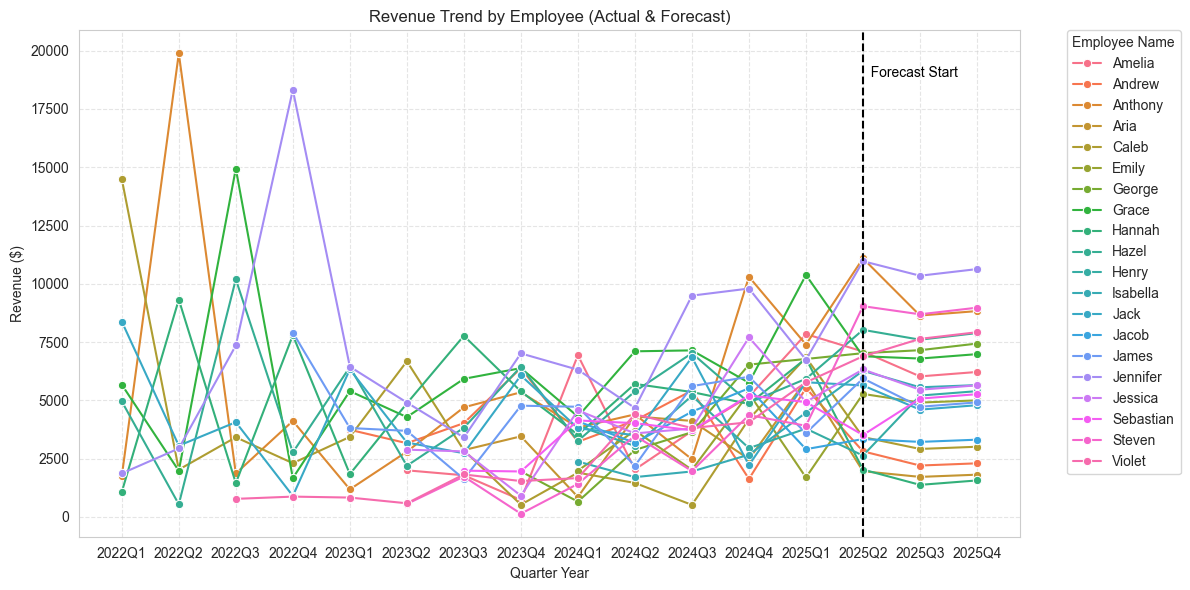

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Quarter_Year' to a categorical type to maintain order
combined_revenue['Quarter_Year'] = pd.Categorical(combined_revenue['Quarter_Year'], 
                                                  categories=sorted(combined_revenue['Quarter_Year'].unique()), 
                                                  ordered=True)

# Identify the separation point (first forecasted quarter)
forecast_start = '2025Q2'

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_revenue, x='Quarter_Year', y='Revenue_Actual_Forecast', hue='Employee_Name', marker='o')

# Add a vertical line to separate actual vs forecasted data
plt.axvline(x=forecast_start, color='black', linestyle='--')

# Annotate the vertical line close to its location
plt.text(forecast_start, combined_revenue['Revenue_Actual_Forecast'].max() * 0.95, '  Forecast Start', color='black', ha='left')

# Improve plot readability
plt.xticks(rotation=0)  # Rotate x-axis labels for better visibility
plt.title("Revenue Trend by Employee (Actual & Forecast)")
plt.xlabel("Quarter Year")
plt.ylabel("Revenue ($)")

# Add the legend outside the figure on the right
plt.legend(title="Employee Name", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Add grid lines for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Make sure the plot fits nicely without clipping
plt.tight_layout()

# Show the plot
plt.show()


### Annual Growth Analysis 

On an annualized basis, the data for 2025, including the forecast, suggests an overall growth in revenue. Considering that this approach is conservative, we exhibit high levels of confidence in the forecast. The trend indicates a stable upward trajectory, and the model's reliability supports the prediction of continued growth in annual revenues for the year ahead. This level of forecast confidence ensures that the projections are robust and grounded in solid historical data.

In [199]:
# Extract Year from Quarter_Year (first 4 characters)
combined_revenue['Year'] = combined_revenue['Quarter_Year'].str[:4]

# Group by Employee_Name and Year, then sum Revenue
combined_revenue_grouped = combined_revenue.groupby(['Employee_Name', 'Year'], as_index=False)['Revenue_Actual_Forecast'].sum()

# Group by Year and calculate the total revenue for each year
annual_revenue_total = combined_revenue_grouped.groupby('Year')['Revenue_Actual_Forecast'].sum().reset_index()

# Calculate the revenue growth rate for each year
annual_revenue_total['Revenue_Growth_Rate'] = annual_revenue_total['Revenue_Actual_Forecast'].pct_change() * 100

# Format the Revenue Growth Rate as percentage
annual_revenue_total['Revenue_Growth_Rate'] = annual_revenue_total['Revenue_Growth_Rate'].apply(lambda x: f"{x:.2f}%" if not pd.isna(x) else "N/A")

# Print the annual total revenue and growth rates
print(annual_revenue_total)


   Year  Revenue_Actual_Forecast Revenue_Growth_Rate
0  2022            168690.527475                 N/A
1  2023            190192.299957              12.75%
2  2024            332440.364668              74.79%
3  2025            451538.225294              35.83%


Although at the annual level the growth rate appears to be lower than in **2024**, the total annual growth rate for **2025** still promises to be positive, with an expected increase of around **35%**. This suggests a healthy overall growth despite a more moderate rate compared to the previous year.


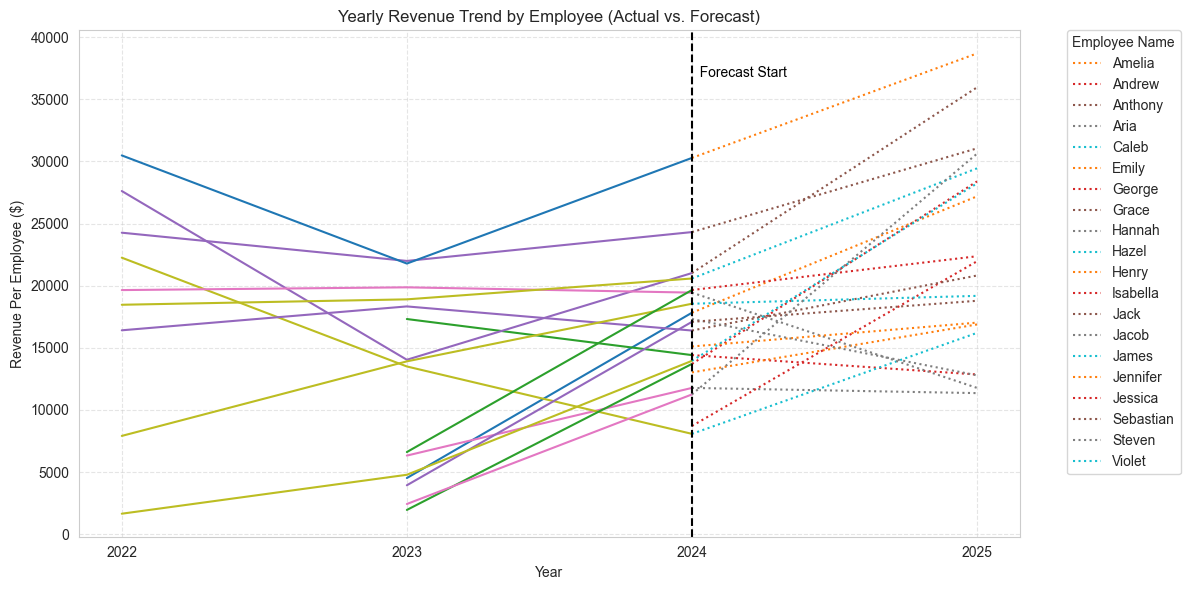

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert 'Year' to categorical type to maintain order
combined_revenue_grouped['Year'] = pd.Categorical(combined_revenue_grouped['Year'], 
                                                  categories=sorted(combined_revenue_grouped['Year'].unique()), 
                                                  ordered=True)

# Define the forecast start year (2024 onwards)
forecast_start = '2025'
actual_end = '2024'

# Create the plot
plt.figure(figsize=(12, 6))

# Keep track of employees present in 2025 for the legend
employees_2025 = set(combined_revenue_grouped[combined_revenue_grouped['Year'] == '2025']['Employee_Name'])

# Plot each employee separately
for employee in combined_revenue_grouped['Employee_Name'].unique():
    employee_data = combined_revenue_grouped[combined_revenue_grouped['Employee_Name'] == employee]
    
    # Separate actual vs. forecasted data
    actual_data = employee_data[employee_data['Year'] < forecast_start]
    forecast_data = employee_data[employee_data['Year'] >= actual_end]
    
    # Plot actual revenue before the forecasted period (solid line)
    if not actual_data.empty:
        sns.lineplot(data=actual_data, x='Year', y='Revenue_Actual_Forecast', label=None, linestyle='-')
    
    # Plot the forecasted period (starting from 2024) as a dotted line
    if not forecast_data.empty:
        sns.lineplot(data=forecast_data, x='Year', y='Revenue_Actual_Forecast', label=employee if employee in employees_2025 else None, linestyle='dotted')

# Improve plot readability
plt.xticks(rotation=0)
plt.title("Yearly Revenue Trend by Employee (Actual vs. Forecast)")
plt.xlabel("Year")
plt.ylabel("Revenue Per Employee ($)")

# Add a legend showing only employees from 2025
plt.legend(title="Employee Name", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

# Annotate the vertical line close to its location
plt.text(actual_end, combined_revenue_grouped['Revenue_Actual_Forecast'].max() * 0.95, '  Forecast Start', color='black', ha='left')

# Add a vertical line to separate actual vs forecasted data
plt.axvline(x=actual_end, color='black', linestyle='--')

# Add gridlines for clarity
plt.grid(True, linestyle='--', alpha=0.5)

# Make sure the plot fits without clipping
plt.tight_layout()

# Show the plot
plt.show()


In [201]:
# Group by Employee_Name and Year, summing the revenue for each year
annual_revenue = combined_revenue_grouped.groupby(['Employee_Name', 'Year'])['Revenue_Actual_Forecast'].sum().reset_index()

# Pivot the table to have revenue per year for each employee
annual_revenue_pivot = annual_revenue.pivot(index='Employee_Name', columns='Year', values='Revenue_Actual_Forecast')

# Calculate the revenue growth rate from 2024 to 2025
annual_revenue_pivot['Revenue_Growth_Rate_Forecast'] = (annual_revenue_pivot['2025'] - annual_revenue_pivot['2024']) / annual_revenue_pivot['2024'] * 100

# Filter for employees with data for 2025
revenue_growth_2025 = annual_revenue_pivot[['2025', 'Revenue_Growth_Rate_Forecast']].reset_index()

# Sort by 2025 revenue
revenue_growth_2025_sorted = revenue_growth_2025.sort_values(by='2025', ascending=False)

# Format 
revenue_growth_2025_sorted['Revenue_Growth_Rate_Forecast'] = revenue_growth_2025_sorted['Revenue_Growth_Rate_Forecast'].apply(lambda x: f"{x:.2f}%")

# Rename
revenue_growth_2025_sorted = revenue_growth_2025_sorted.rename(columns={'2025': 'Revenue_2025_Forecast'})

# Print the sorted table
print(revenue_growth_2025_sorted)


Year Employee_Name  Revenue_2025_Forecast Revenue_Growth_Rate_Forecast
15        Jennifer           38687.781600                       27.77%
2          Anthony           35956.269110                       71.10%
7            Grace           31048.150527                       27.71%
18          Steven           30619.071530                      172.21%
9            Hazel           29439.901898                       43.08%
6           George           28391.251054                      107.17%
19          Violet           28229.711304                      102.35%
0           Amelia           27186.859938                       52.54%
16         Jessica           22367.121387                       13.83%
11        Isabella           21962.716088                      152.13%
12            Jack           20816.402459                       27.01%
14           James           19179.721498                        3.41%
17       Sebastian           18783.688158                        9.92%
10    

C:\Users\dried\AppData\Local\Temp\ipykernel_6204\969331248.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  annual_revenue = combined_revenue_grouped.groupby(['Employee_Name', 'Year'])['Revenue_Actual_Forecast'].sum().reset_index()


Based on this analysis, we see that at the annual level in 2025, a number of employees are expected to significantly surpass their 2024 results, with growth rates equal or exceeding 100%. Notably, **Steven**, **George**, **Violet**, **Isabella**, and **Caleb** are projected to achieve this impressive growth.

On the other hand, some employees are anticipated to underperform compared to their 2024 results, with negative growth. These employees include **Andrew**, **Jacob**, **Hannah**, and **Aria**.

The remaining employees are expected to show moderate growth, slightly outperforming their 2024 results with more modest increases.


# Identify Patterns in the Data Related to Employee Success

# Correlation Driven Analysis of Data Patterns Contributing to Employee Success

To answer the question on what patters in data can be observed, we will rely on the visualizations that we've done earlier in this work, and also on coefficient analysis, correlation analysis, and our own business accumen. 

In a sense, this is a reverse qustiopn to what factors are positively and negatively correlated to the employee susccess. Let's build a visualization that shows the correlation of the variables to revenue.

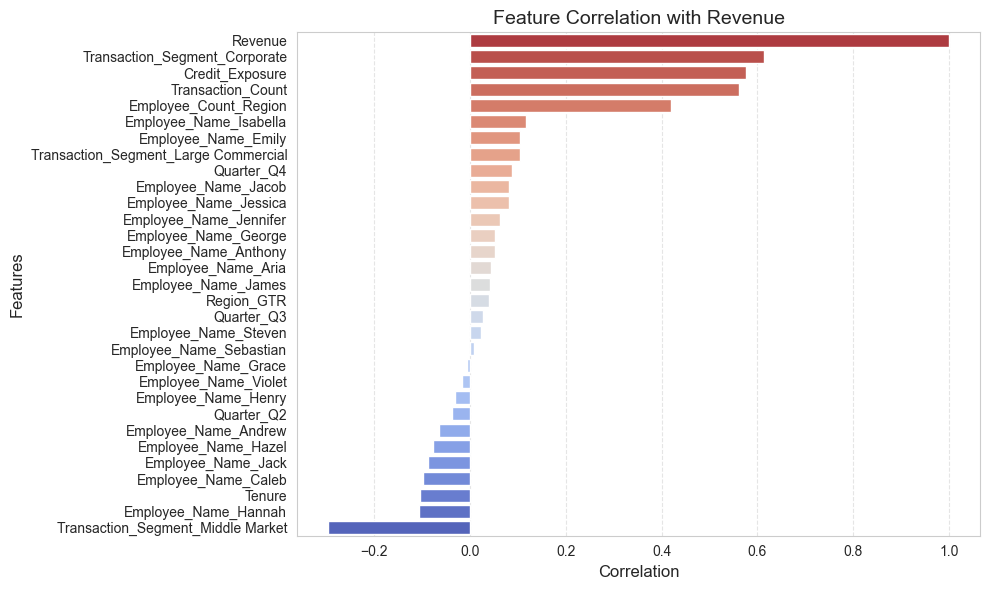

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

# Extract correlations with 'Revenue' and sort them
revenue_correlation = correlation_matrix['Revenue'].sort_values(ascending=False)

# Convert the Series to a DataFrame for visualization
revenue_correlation_df = revenue_correlation.reset_index()
revenue_correlation_df.columns = ['Feature', 'Correlation']

# Create a bar plot with an inverted color palette and resolve the warning
plt.figure(figsize=(10, 6))
sns.barplot(data=revenue_correlation_df, x='Correlation', y='Feature', hue='Feature', palette='coolwarm_r', dodge=False, legend=False)

# Enhance readability
plt.title('Feature Correlation with Revenue', fontsize=14)
plt.xlabel('Correlation', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Display the visualization
plt.tight_layout()
plt.show()


### Key Drivers of Revenue
The chart identifies features with strong positive correlations to revenue, such as `Transaction_Segment_Corporate`, `Transaction_Count`, `Transaction_Segment_Large_Commercial`, and `Credit_Exposure`. These insights highlight the importance of prioritizing and optimizing these factors to drive revenue growth. Large commercial and corporate sectors appear to offer the most lucrative opportunities, with the number of transactions closely linked to revenue. Additionally, the branch size correlates positively with revenue, reflecting the trend that larger branches often cater to bigger, more profitable clients.

### Areas of Concern
Features like `Transaction_Segment_Middle Market` and certain employee names (e.g., `Employee_Name_Hannah`) show strong negative correlations with revenue, which could indicate potential inefficiencies or challenges. This calls for closer evaluation of the business acumen, activity levels, and productivity of the employees involved. Furthermore, the profitability of the middle market segment may need to be reassessed, raising questions about whether it should continue as is or undergo restructuring to improve outcomes.

### Strategic Planning
By visualizing how features like `Quarter` and `Transaction_Count` correlate with revenue, businesses can formulate targeted strategies that focus on customer segments or seasons with the greatest impact. This data-driven approach enhances strategic decision-making and resource allocation.

### Tenure
The visualization indicates a negative correlation between employee tenure and revenue, suggesting that more frequent rotations or lateral moves could invigorate the sales process and enhance overall results. This insight advocates for dynamic personnel strategies to optimize sales effectiveness.

### Seasonality
The data reveals a seasonality effect, with sales peaking in the final quarter of the year. This underscores the need for increased promotional efforts and sales activities during the first three quarters to sustain revenue levels throughout the year.

### Employee Rewards
Employees whose names are strongly and positively correlated with revenue may warrant consideration for rewards, promotions, and positive performance appraisals. Recognizing high performers can drive motivation and reinforce positive outcomes.

### Region
Although there is limited correlation between region and revenue, the size of the employee pool within a branch shows a strong positive correlation. This suggests that larger teams often foster greater individual contributions and are more equipped to service high-value clients, resulting in increased revenue generation.



### Correlation Analysis Conclusion: Patterns Driving Employee Success

The correlation analysis provides key insights into the factors and patterns that contribute to employee success:

1. **Positive Correlations**:
   - Certain employee-specific features are positively correlated with revenue, showcasing their effectiveness in driving business outcomes. These employees likely excel in client interactions, sales management, or operational efficiency.
   - Larger team sizes within regions are associated with higher revenue, highlighting the importance of collaboration and resource availability in achieving success.

2. **Negative Correlations**:
   - Some employees and business segments show negative correlations with revenue. This may indicate potential inefficiencies or challenges that require focused training, process improvements, or strategic realignment.

3. **Actionable Insights**:
   - High-performing individuals and larger teams should be nurtured and optimized to maximize their contributions.
   - Underperforming areas should be evaluated to determine opportunities for intervention and improvement.

This analysis underscores the importance of identifying and fostering the factors that lead to employee success while addressing areas of concern to enhance overall performance.

## Regression Driven Analysis of Data Patterns

### Feature Selection Principles and Their Impact  
For the logistic regression model, we selected features based on their high F-scores and a p-value threshold of ≥ 5%. Only features satisfying these criteria were included, ensuring their significance and contribution to the model. Below is a table demonstrating the coefficients attributed to such features within the regression equation. 

The selected features collectively highlight the main drivers of revenue and offer actionable insights. They emphasize the importance of targeting high-value market segments, maintaining transaction volume, assessing individual employee performance, optimizing team size, and leveraging seasonal opportunities. These findings provide a robust basis for refining strategies and improving revenue forecasting.

In [216]:
import pandas as pd

# Assuming 'selected_features' is the list of feature names used for training the model
# Retrieve the model's coefficients
coefficients = model.coef_

# Create a DataFrame to display feature names and their corresponding coefficients
coefficients_table = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients
})

# Sort the table by coefficient values (optional)
coefficients_table = coefficients_table.sort_values(by='Coefficient', ascending=False).reset_index(drop=True)

# Display the table
display(coefficients_table)


,Feature,Coefficient
0,Transaction_Segment_Corporate,3757.353690
1,Transaction_Segment_Large Commercial,1862.999631
2,Transaction_Segment_Middle Market,1221.940509
3,Transaction_Count,851.002771
4,Employee_Name_Isabella,362.683276
5,Employee_Name_Jacob,323.955261
6,Employee_Name_Emily,196.348831
7,Employee_Name_Jessica,165.317716
8,Employee_Count_Region,153.916430
9,Employee_Name_Caleb,143.614171


#### Transaction_Segment_Corporate
With the highest coefficient, this feature has the most substantial positive impact on revenue. It indicates that transactions within the corporate segment are highly profitable and drive significant revenue growth.

#### Transaction_Segment_Large Commercial
This feature also demonstrates a strong positive impact on revenue, highlighting the large commercial segment as another major driver of financial performance.

#### Transaction_Segment_Middle Market
While it has a positive coefficient, its impact is comparatively smaller, suggesting moderate profitability in the middle market segment.

#### Transaction_Count
The positive coefficient for this feature underscores the direct relationship between the number of transactions and revenue, confirming that maintaining transaction volume contributes to greater revenue generation.

#### Employee_Name Features (Isabella, Jacob, Emily, Jessica, Caleb)
These features reflect the individual contributions of employees to revenue. Positive coefficients indicate that these employees are associated with increased revenue, possibly due to their effectiveness in sales or client interactions.

#### Employee_Count_Region
The positive correlation suggests that regions with larger teams tend to generate higher revenue, emphasizing the importance of team size in achieving sales targets.

#### Quarter_Q4
Although its coefficient is relatively small, this feature points to a seasonal effect, with the fourth quarter contributing positively to revenue, potentially due to year-end business activities and promotions.

### Regression Analysis Conclusion: Employee Success and Revenue-Driving Factors

The regression analysis highlights the most influential features impacting revenue while underscoring the critical role of employee success in achieving financial performance:

1. **High-Impact Features**:
   - Features like `Transaction_Segment_Corporate`, `Transaction_Segment_Large Commercial`, and `Transaction_Count` emerged as the strongest revenue drivers. These findings emphasize the importance of effective employee involvement in high-value market segments and maintaining transaction volume through well-executed sales strategies.

2. **Employee Contributions**:
   - Employee-specific features, such as names positively correlated with revenue, reflect their individual success in driving profitability. These employees may exhibit strong sales skills, high productivity, or exceptional client management, making them indispensable contributors to overall revenue growth.
   - Conversely, employees with weaker or negative correlations require deeper analysis to identify areas for improvement—such as training, better alignment with business objectives, or changes in role allocation.

3. **Team Dynamics**:
   - Larger team sizes correlate positively with revenue, suggesting that collaborative efforts within larger teams foster successful individual contributions. Employees in well-resourced teams are better positioned to work with high-value clients and execute more impactful sales activities.

4. **Seasonal Trends and Employee Focus**:
   - Seasonal insights, like Q4's strong performance, underline the need for employees to align their efforts with seasonal opportunities. Strategic guidance and rewards can inspire employees to maximize their output during critical periods.

5. **Actionable Strategies**:
   - Recognizing and rewarding high-performing employees can reinforce their impact, while investing in underperforming individuals can improve overall team effectiveness. Combining these efforts with strategic resource allocation ensures sustained employee success and revenue optimization.

In summary, the regression analysis connects the drivers of revenue to employee success, emphasizing the value of individual contributions, teamwork, and strategic employee management in achieving optimal financial outcomes.

